## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
PRE_ACTIVATE = [True, False]
MOMENTUM = 0.95

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (use_preact, bz) in enumerate(itertools.product(PRE_ACTIVATE, BATCH_SIZE)):
    print("Numbers of exp: %i, use_preact: %s, batch_size: %i" % (i, use_preact, bz))
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=use_preact)
    model.summary()
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bz, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = (f"Pre_activation: {use_preact}, batch_size: {bz}")
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, use_preact: True, batch_size: 2


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 97s 4ms/step - accuracy: 0.1479 - loss: 2.2924 - val_accuracy: 0.2345 - val_loss: 2.2520
Epoch 2/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - accuracy: 0.1739 - loss: 2.2299 - val_accuracy: 0.2262 - val_loss: 2.3432
Epoch 3/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - accuracy: 0.1757 - loss: 2.2153 - val_accuracy: 0.2362 - val_loss: 2.2933
Epoch 4/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 256s 10ms/step - accuracy: 0.1737 - loss: 2.2212 - val_accuracy: 0.2301 - val_loss: 2.3924
Epoch 5/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 227s 9ms/step - accuracy: 0.1849 - loss: 2.2040 - val_accuracy: 0.2388 - val_loss: 2.4450
Epoch 6/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - accuracy: 0.1851 - loss: 2.2062 - val_accuracy: 0.2543 - val_loss: 2.3107
Epoch 7/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - accuracy: 0.1925 - loss: 2.1967 - val_accuracy: 0.2309 - val_loss: 2.5429
Epoch 8/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - accurac

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.3455 - loss: 1.8344 - val_accuracy: 0.4120 - val_loss: 1.6554
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4457 - loss: 1.5541 - val_accuracy: 0.3894 - val_loss: 1.6897
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4785 - loss: 1.4616 - val_accuracy: 0.4832 - val_loss: 1.4578
Epoch 4/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5097 - loss: 1.3844 - val_accuracy: 0.5045 - val_loss: 1.3869
Epoch 5/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5340 - loss: 1.3218 - val_accuracy: 0.4854 - val_loss: 1.4478
Epoch 6/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5508 - loss: 1.2592 - val_accuracy: 0.5219 - val_loss: 1.3492
Epoch 7/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5659 - loss: 1.2234 - val_accuracy: 0.5115 - val_loss: 1.4019
Epoch 8/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5791 - loss: 1

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3640 - loss: 1.7805 - val_accuracy: 0.4081 - val_loss: 1.6110
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4780 - loss: 1.4653 - val_accuracy: 0.3783 - val_loss: 1.8338
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5198 - loss: 1.3498 - val_accuracy: 0.4387 - val_loss: 1.5858
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5488 - loss: 1.2734 - val_accuracy: 0.4614 - val_loss: 1.5197
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5744 - loss: 1.2029 - val_accuracy: 0.4902 - val_loss: 1.4427
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5931 - loss: 1.1405 - val_accuracy: 0.5013 - val_loss: 1.4090
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6155 - loss: 1.0758 - val_accuracy: 0.4765 - val_loss: 1.4772
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6373 - loss: 1.0233 - 

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3787 - loss: 1.7610 - val_accuracy: 0.3677 - val_loss: 1.7953
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5072 - loss: 1.3874 - val_accuracy: 0.4275 - val_loss: 1.6079
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5523 - loss: 1.2583 - val_accuracy: 0.3926 - val_loss: 1.7367
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5903 - loss: 1.1583 - val_accuracy: 0.3603 - val_loss: 1.9532
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6137 - loss: 1.0799 - val_accuracy: 0.4019 - val_loss: 1.7782
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6443 - loss: 1.0047 - val_accuracy: 0.4416 - val_loss: 1.6043
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6744 - loss: 0.9212 - val_accuracy: 0.4050 - val_loss: 1.7434
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6984 - loss: 0.8520 - val_accuracy: 0.

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3833 - loss: 1.7498 - val_accuracy: 0.3089 - val_loss: 1.9270
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5144 - loss: 1.3714 - val_accuracy: 0.3913 - val_loss: 1.7333
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5609 - loss: 1.2405 - val_accuracy: 0.3594 - val_loss: 1.8304
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5994 - loss: 1.1306 - val_accuracy: 0.4286 - val_loss: 1.6246
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6303 - loss: 1.0462 - val_accuracy: 0.4102 - val_loss: 1.7153
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6571 - loss: 0.9686 - val_accuracy: 0.4285 - val_loss: 1.6996
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6856 - loss: 0.8903 - val_accuracy: 0.4321 - val_loss: 1.6738
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7175 - loss: 0.8126 - val_accuracy: 0.

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.1486 - loss: 2.3515 - val_accuracy: 0.2103 - val_loss: 2.4660
Epoch 2/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.1688 - loss: 2.2326 - val_accuracy: 0.2182 - val_loss: 35.3545
Epoch 3/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.1769 - loss: 2.2190 - val_accuracy: 0.2024 - val_loss: 29.9252
Epoch 4/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.1791 - loss: 2.2179 - val_accuracy: 0.2119 - val_loss: 45.7943
Epoch 5/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.1764 - loss: 2.2242 - val_accuracy: 0.2127 - val_loss: 35.9646
Epoch 6/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.1752 - loss: 2.2272 - val_accuracy: 0.1840 - val_loss: 65.9783
Epoch 7/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.1787 - loss: 2.2163 - val_accuracy: 0.2108 - val_loss: 66.4446
Epoch 8/50
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accu

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.3127 - loss: 1.9371 - val_accuracy: 0.3439 - val_loss: 1.8849
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4008 - loss: 1.6920 - val_accuracy: 0.4107 - val_loss: 1.6805
Epoch 3/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4217 - loss: 1.6115 - val_accuracy: 0.4544 - val_loss: 1.5370
Epoch 4/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4479 - loss: 1.5570 - val_accuracy: 0.4523 - val_loss: 1.5407
Epoch 5/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4658 - loss: 1.5101 - val_accuracy: 0.4776 - val_loss: 1.4785
Epoch 6/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4690 - loss: 1.4924 - val_accuracy: 0.4244 - val_loss: 1.6331
Epoch 7/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4814 - loss: 1.4612 - val_accuracy: 0.4600 - val_loss: 1.5308
Epoch 8/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.4922 - loss: 1

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.3394 - loss: 1.8740 - val_accuracy: 0.3659 - val_loss: 1.7825
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.4178 - loss: 1.6205 - val_accuracy: 0.2966 - val_loss: 2.3034
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.4555 - loss: 1.5273 - val_accuracy: 0.4263 - val_loss: 1.6374
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4760 - loss: 1.4684 - val_accuracy: 0.4616 - val_loss: 1.5186
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.5028 - loss: 1.4081 - val_accuracy: 0.4874 - val_loss: 1.4596
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.5148 - loss: 1.3609 - val_accuracy: 0.4693 - val_loss: 1.5054
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.5274 - loss: 1.3178 - val_accuracy: 0.4594 - val_loss: 1.5124
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5341 - loss:

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3567 - loss: 1.8463 - val_accuracy: 0.3376 - val_loss: 1.8388
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4736 - loss: 1.4934 - val_accuracy: 0.3841 - val_loss: 1.7887
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5005 - loss: 1.4057 - val_accuracy: 0.3707 - val_loss: 1.7977
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5230 - loss: 1.3506 - val_accuracy: 0.4282 - val_loss: 1.6151
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5485 - loss: 1.2698 - val_accuracy: 0.4568 - val_loss: 1.5656
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5641 - loss: 1.2313 - val_accuracy: 0.4806 - val_loss: 1.4830
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5830 - loss: 1.1808 - val_accuracy: 0.5067 - val_loss: 1.3954
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5955 - loss: 1.1384 - val_accuracy: 0.

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3606 - loss: 1.8616 - val_accuracy: 0.3515 - val_loss: 1.8225
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4721 - loss: 1.4911 - val_accuracy: 0.3763 - val_loss: 1.7930
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5085 - loss: 1.3855 - val_accuracy: 0.4202 - val_loss: 1.6219
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5353 - loss: 1.3046 - val_accuracy: 0.3515 - val_loss: 1.8812
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5558 - loss: 1.2532 - val_accuracy: 0.3559 - val_loss: 1.8680
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5738 - loss: 1.2046 - val_accuracy: 0.3957 - val_loss: 1.7807
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5946 - loss: 1.1549 - val_accuracy: 0.3969 - val_loss: 1.7174
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6066 - loss: 1.1103 - val_accuracy: 0.

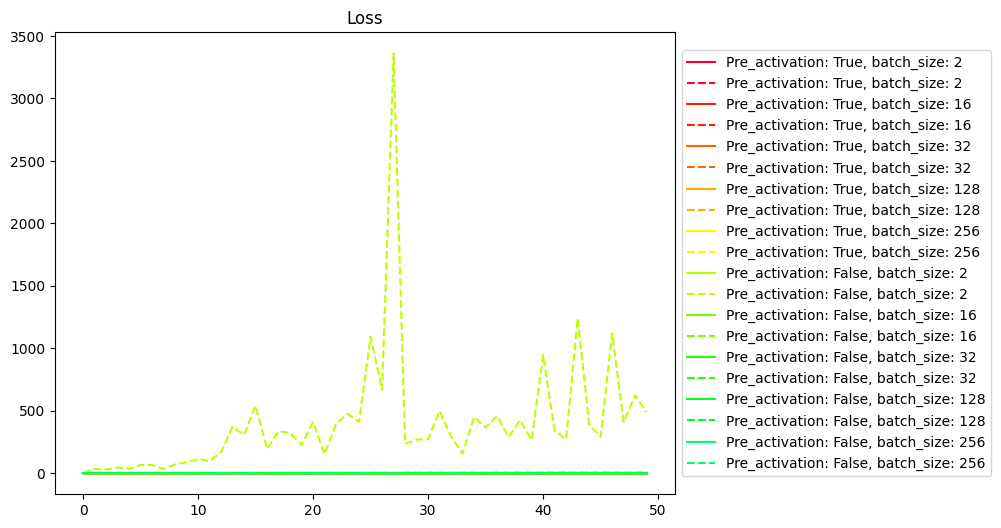

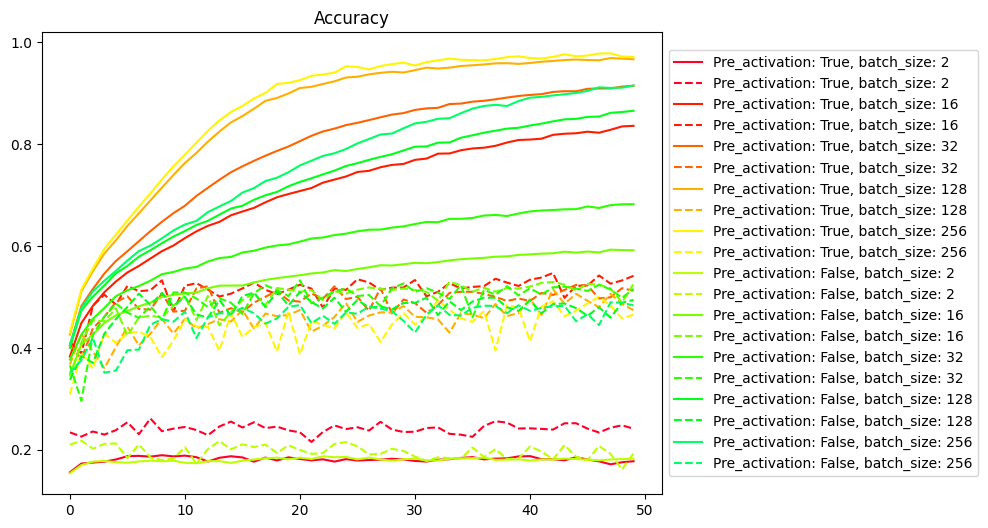

In [9]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()